### Configuração Inicial

In [54]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout
from tensorflow.keras.models import Model

# Carregar dados
users = pd.read_csv("users.csv")
movies = pd.read_csv("movies.csv")
interactions = pd.read_csv("interactions.csv")

In [97]:
target_genres = ["Fantasia", "Família"]

# Filtrar filmes que contêm TODOS os gêneros
filtered_movies = movies[
    movies["genres"].apply(
        lambda x: all(genre in x for genre in target_genres)
    )
]

# Mostrar resultados
if not filtered_movies.empty:
    print("Filmes encontrados com os gêneros", target_genres, ":\n")
    print(filtered_movies[["movieId", "title", "genres"]])
else:
    print("Nenhum filme encontrado com todos os gêneros especificados.")

Filmes encontrados com os gêneros ['Fantasia', 'Família'] :

                                  movieId  \
51   09352cf7-d77b-47af-b09a-25319d9706b1   
104  b9e5dce8-f88c-4b5a-ae0c-23bef0503bb0   
110  95b08102-d4cf-46bd-bd45-f0f4195b7fee   
133  0a2e21da-fe10-4c0b-a2a0-c0dd1d41ea28   
138  3b2d9daf-bfb9-4b02-8096-72fc02c5ab83   
148  eaab32ca-37dc-4254-87ee-7eacda392e8d   
188  5a4f7e86-ac1e-452f-b95e-8341f995aeae   
189  ef9b4496-7664-41d1-ae71-95ee11fad82f   
193  bbd96150-8fb0-46b1-aaad-076e9095c16a   

                                                 title  \
51   The Chronicles of Narnia: The Lion, the Witch ...   
104                                    Kung Fu Panda 4   
110                                                 IF   
133                                         Spellbound   
138                                              Moana   
148                        The Super Mario Bros. Movie   
188                                              Shrek   
189                     

### Pré-processamento dos Dados

#### a) Processar gêneros

In [56]:
import ast
from sklearn.preprocessing import MultiLabelBinarizer

# Converter a coluna de gêneros preferidos de forma segura
def safe_convert_to_list(x):
    try:
        return ast.literal_eval(x) if isinstance(x, str) else []
    except (ValueError, SyntaxError):
        return []

users["preferredGenres"] = users["preferredGenres"].apply(safe_convert_to_list)

# Processar gêneros dos filmes (tratando valores nulos e normalizando)
movies["genres"] = movies["genres"].apply(
    lambda x: [g.strip().title() for g in x.split(",")] if pd.notnull(x) else []
)

# Criar lista única de todos os gêneros
all_genres = set()

# Processar gêneros dos usuários
for genres in users["preferredGenres"]:
    all_genres.update([g.strip().title() for g in genres])

# Processar gêneros dos filmes
for genres in movies["genres"]:
    all_genres.update([g.strip().title() for g in genres])

all_genres = sorted(list(all_genres))

# Codificador multi-hot
mlb = MultiLabelBinarizer(classes=all_genres)
mlb.fit([all_genres])  # Forçar o mesmo conjunto de classes

# Aplicar codificação
users["preferredGenres_encoded"] = users["preferredGenres"].apply(
    lambda x: mlb.transform([x])[0].tolist()
)

movies["genre_encoded"] = movies["genres"].apply(
    lambda x: mlb.transform([x])[0].tolist()
)

/home/pedro/.pyenv/versions/3.11.0/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['Ficção científica'] will be ignored
  warnings.warn(
/home/pedro/.pyenv/versions/3.11.0/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['Cinema TV', 'Ficção científica'] will be ignored
  warnings.warn(
/home/pedro/.pyenv/versions/3.11.0/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['Cinema TV'] will be ignored
  warnings.warn(


In [64]:
movies

,movieId,title,genres,genre_encoded,movie_id_encoded
0,c36b8c6f-addf-4c62-9109-5e6c47ca6935,Sonic the Hedgehog 3,"[Ação, Ficção Científica, Comédia, Família]","[0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...",151
1,d23f94f0-32cb-4925-acc5-6deeadd3721f,Kraven the Hunter,"[Ação, Ficção Científica, Aventura, Fantasia, ...","[0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, ...",161
2,b5313d17-29b6-4fb5-8164-ff79b5cf9627,Back in Action,"[Ação, Comédia]","[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",136
3,ea105795-fc9c-4154-944b-d9402d2aeafb,Nosferatu,[Terror],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",178
4,140a1ecc-9afd-4264-abbc-0999bcee2804,Mufasa: The Lion King,"[Aventura, Família, Animação]","[1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",13
...,...,...,...,...,...
195,bf3db485-8add-4bc6-a262-9a1a88cbf85d,The Conjuring,"[Terror, Thriller]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",146
196,373c428f-276f-46d4-836e-24009e23ae9b,Dune,"[Ficção Científica, Aventura]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",35
197,6c629676-d866-4d01-9f51-a918731f7731,Death Note Relight 2: L's Successors,"[Cinema Tv, Thriller, Animação, Crime, Drama, ...","[1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, ...",74
198,11f1d592-0627-48c9-8bf7-587b1b6ab534,Harry Potter and the Prisoner of Azkaban,"[Aventura, Fantasia]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",10


In [65]:
users

,id,age,gender,preferredGenres,location,acceptsRecommendations,preferredGenres_encoded,user_id_encoded,age_normalized
0,8d410afe-bcac-412d-876a-164e8e3ee647,18,M,"[Thriller, História, Faroeste]",Porto Alegre,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, ...",55,0.000000
1,41690a70-94f8-4c9f-bd2a-0bcda8e4ba86,37,M,"[Ficção científica, Ação, Fantasia]",Belo Horizonte,False,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",23,0.452381
2,6ef516b8-c939-4073-a5c3-90e2d1e934d0,48,F,"[Fantasia, Guerra, Família]",Recife,True,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, ...",36,0.714286
3,ce1a6638-dcc4-4403-808b-9e5036a17081,46,F,"[Fantasia, Comédia, Aventura]",Curitiba,True,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",81,0.666667
4,123b60a3-8faa-44c4-9f36-9393acdb7c1d,39,M,"[Ficção científica, Guerra, Thriller]",Fortaleza,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",5,0.500000
...,...,...,...,...,...,...,...,...,...
95,30f1f8e8-0622-4861-9ed8-86a5bf56a349,19,M,"[Crime, Romance, Ficção científica]",Rio de Janeiro,False,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",16,0.023810
96,af6ed03c-7a2c-4955-8893-252f47e3ebf6,60,F,"[Guerra, Romance, Música]",Belo Horizonte,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",67,1.000000
97,f0c54e5a-f508-4491-982b-bb16d10da00f,56,F,"[Thriller, Drama, Comédia]",Salvador,False,"[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",92,0.904762
98,f854769b-0c37-4a28-9d2c-8ef7e186d37b,24,F,"[Fantasia, Drama, Cinema TV]",Curitiba,False,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, ...",97,0.142857


#### Codificar IDs

In [57]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Codificar user_id e movie_id
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()

users["user_id_encoded"] = user_encoder.fit_transform(users["id"])
movies["movie_id_encoded"] = movie_encoder.fit_transform(movies["movieId"])
interactions["user_id_encoded"] = user_encoder.transform(interactions["userId"])
interactions["movie_id_encoded"] = movie_encoder.transform(interactions["movieId"])

# Normalizar idade
scaler = MinMaxScaler()
users["age_normalized"] = scaler.fit_transform(users[["age"]])

#### Normalizar features numéricas

In [58]:
scaler = MinMaxScaler()
users["age_normalized"] = scaler.fit_transform(users[["age"]])

### Preparar o Dataset Final

In [59]:
# Merge de dados
merged_data = interactions.merge(
    users[["user_id_encoded", "age_normalized", "gender", "preferredGenres_encoded"]],
    on="user_id_encoded"
).merge(
    movies[["movie_id_encoded", "genre_encoded"]],
    on="movie_id_encoded"
)

# Converter arrays para numpy
merged_data["preferredGenres_encoded"] = merged_data["preferredGenres_encoded"].apply(
    lambda x: np.array(x, dtype=np.float32)
)
merged_data["genre_encoded"] = merged_data["genre_encoded"].apply(
    lambda x: np.array(x, dtype=np.float32)
)

# Criar target (normalização do tempo assistido)
merged_data["target"] = merged_data["totalWatchTime"] / merged_data["totalWatchTime"].max()

In [78]:
# Corrigir para usar as colunas corretas:
merged_data["user_features"] = merged_data["preferredGenres_encoded"]  # Já está codificado
merged_data["movie_features"] = merged_data["genre_encoded"]  # Já está codificado

# Adicionar idade normalizada às features do usuário
merged_data["user_features"] = merged_data.apply(
    lambda row: np.concatenate([row["preferredGenres_encoded"], [row["age_normalized"]]]),
    axis=1
)

### Construção do Modelo

In [73]:
from tensorflow.keras.layers import Input, Concatenate, Dense, Dropout
from tensorflow.keras.models import Model

#-----------------------------------------------------------
# Camadas de Input (APENAS features, sem IDs)
#-----------------------------------------------------------
user_features_input = Input(shape=(20,), name="user_features")  # 20 features do usuário (age + 19 gêneros)
movie_features_input = Input(shape=(19,), name="movie_features")  # 19 features do filme (gêneros)

#-----------------------------------------------------------
# Concatenar as Features
#-----------------------------------------------------------
combined = Concatenate()([
    user_features_input,
    movie_features_input
])  # Shape resultante: (None, 39)

#-----------------------------------------------------------
# Camadas Densas
#-----------------------------------------------------------
x = Dense(128, activation="relu")(combined)
x = Dropout(0.3)(x)
x = Dense(64, activation="relu")(x)
output = Dense(1, activation="sigmoid")(x)  # Saída entre 0 e 1

#-----------------------------------------------------------
# Modelo Final (APENAS 2 inputs)
#-----------------------------------------------------------
model = Model(
    inputs=[user_features_input, movie_features_input],  # Sem user_id/movie_id
    outputs=output
)

model.compile(optimizer="adam", loss="mse", metrics=["mae"])

### Treinamento

In [79]:
import numpy as np
from sklearn.model_selection import train_test_split

# 1. Criar X como dicionário de arrays 2D
X = {
    "user_features": np.vstack(merged_data["user_features"].values),
    "movie_features": np.vstack(merged_data["movie_features"].values)
}

y = merged_data["target"].values

# 2. Verificar dimensões
print("Dimensões de X:")
print("user_features:", X["user_features"].shape)
print("movie_features:", X["movie_features"].shape)
print("y:", y.shape)

# 3. Divisão treino-teste
indices = np.arange(len(y))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)

X_train = {
    "user_features": X["user_features"][train_indices, :],
    "movie_features": X["movie_features"][train_indices, :]
}

X_test = {
    "user_features": X["user_features"][test_indices, :],
    "movie_features": X["movie_features"][test_indices, :]
}

y_train = y[train_indices]
y_test = y[test_indices]

# 4. Treinar o modelo
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=64,
    shuffle=True
)

Dimensões de X:
user_features: (500, 20)
movie_features: (500, 19)
y: (500,)
Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0767 - mae: 0.2385 - val_loss: 0.0861 - val_mae: 0.2587
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0744 - mae: 0.2380 - val_loss: 0.0857 - val_mae: 0.2578
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0771 - mae: 0.2423 - val_loss: 0.0859 - val_mae: 0.2575
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0743 - mae: 0.2373 - val_loss: 0.0869 - val_mae: 0.2582
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0692 - mae: 0.2299 - val_loss: 0.0866 - val_mae: 0.2579
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0725 - mae: 0.2346 - val_loss: 0.0857 - val_mae: 0.2578
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0691 - mae: 0.2292 - val_loss: 0.0865 - val_mae: 0.2583
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0688 - mae: 0.2278 - val_loss: 0.0870 - val_mae: 0.2587
Epo

In [32]:
# Verificar consistência das amostras
assert len(X["user_id"]) == len(X["movie_id"]) == len(X["user_features"]) == len(X["movie_features"]), "Dimensões inconsistentes!"
print("Número de amostras:", len(X["user_id"]))  # Deve retornar 500 (exemplo)

Número de amostras: 500


In [33]:
# Divisão treino/teste para dicionários
indices = np.arange(len(X["user_id"]))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)

# Separar dados
X_train = {key: val[train_indices] for key, val in X.items()}
X_test = {key: val[test_indices] for key, val in X.items()}
y_train = y[train_indices]
y_test = y[test_indices]

In [34]:
y_train

array([0.53666667, 0.145     , 0.92166667, 0.435     , 0.525     ,
       0.79      , 0.38166667, 0.75      , 0.745     , 0.365     ,
       0.90666667, 0.24833333, 0.34166667, 0.91      , 0.85333333,
       0.06      , 0.97      , 0.37666667, 0.61666667, 0.34666667,
       0.59333333, 0.82166667, 0.38666667, 0.9       , 0.41666667,
       0.43666667, 0.88666667, 0.10166667, 0.11666667, 0.36833333,
       0.78666667, 0.44666667, 0.825     , 0.08166667, 0.81      ,
       0.315     , 0.83333333, 0.825     , 0.885     , 0.87833333,
       0.49166667, 0.05166667, 0.07333333, 0.81333333, 0.38      ,
       0.82166667, 0.82833333, 0.18833333, 0.81333333, 0.37166667,
       0.44666667, 0.745     , 0.13166667, 0.61      , 0.695     ,
       0.92166667, 0.98333333, 0.18166667, 0.455     , 0.49      ,
       0.67333333, 0.10166667, 0.79333333, 0.58833333, 0.89666667,
       0.735     , 0.28666667, 0.38666667, 0.40166667, 0.74666667,
       0.82833333, 0.40666667, 0.72166667, 0.755     , 0.065  

### Previsões

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0883 - mae: 0.2488
Test Loss: 0.0955
Test MAE: 0.2608


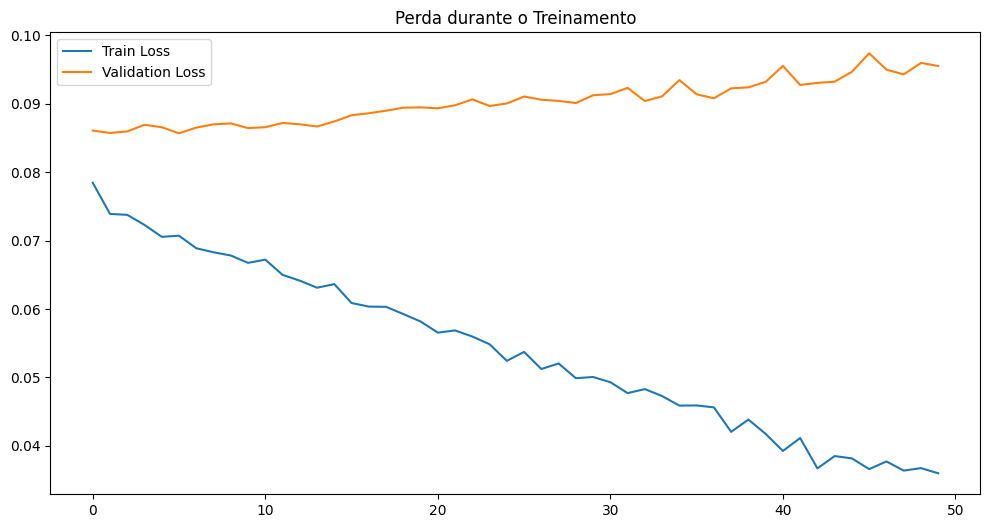

In [80]:
import matplotlib.pyplot as plt

# Avaliar no conjunto de teste
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test MAE: {mae:.4f}")

# Plotar histórico de treinamento
plt.figure(figsize=(12, 6))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Perda durante o Treinamento")
plt.show()

In [98]:
# Exemplo: prever para um usuário e filme específico
# Supondo que você tenha acesso aos dados originais (users.csv e movies.csv)

# Dados de exemplo
user_id = "6ef516b8-c939-4073-a5c3-90e2d1e934d0"
movie_id = "09352cf7-d77b-47af-b09a-25319d9706b1"

user_data = users[users["id"] == user_id].iloc[0]  # Supondo que a coluna de IDs se chama 'id'

# 2. Processar features do usuário
# Converter gêneros para lista e aplicar title case
user_genres = [g.strip().title() for g in user_data["preferredGenres"]]
user_age = user_data["age"]

# Codificar gêneros do usuário (usar o mesmo encoder do treino)
user_genres_encoded = mlb.transform([user_genres])[0]

# Normalizar idade (usar o mesmo scaler do treino)
user_age_normalized = scaler.transform([[user_age]])[0][0]

# Combinar features (gêneros + idade)
user_features = np.concatenate([user_genres_encoded, [user_age_normalized]])

# 3. Buscar dados do filme
movie_data = movies[movies["movieId"] == movie_id].iloc[0]  # Supondo coluna 'movieId'

# 4. Processar features do filme
# Acessar a lista de gêneros já pré-processada
movie_genres = movie_data["genres"]  # Já é uma lista, não uma string!

# Garantir formatação consistente (strip e title case)
movie_genres = [g.strip().title() for g in movie_genres]

# Codificar usando o MultiLabelBinarizer
movie_features = mlb.transform([movie_genres])[0]

# 5. Criar input para o modelo
input_data = {
    "user_features": np.array([user_features], dtype=np.float32),  # (1, 20)
    "movie_features": np.array([movie_features], dtype=np.float32)  # (1, 19)
}

# 6. Fazer previsão
prediction = model.predict(input_data)[0][0]

print(f"Probabilidade de interesse do usuário {user_id} no filme {movie_data['title']}: {prediction:.2%}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

/home/pedro/.pyenv/versions/3.11.0/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Probabilidade de interesse do usuário 6ef516b8-c939-4073-a5c3-90e2d1e934d0 no filme The Chronicles of Narnia: The Lion, the Witch and the Wardrobe: 47.98%


In [99]:
import pandas as pd
import numpy as np

# Dados do usuário específico
user_id = "6ef516b8-c939-4073-a5c3-90e2d1e934d0"
user_data = users[users["id"] == user_id].iloc[0]

# Processar features do usuário (uma única vez)
user_genres = [g.strip().title() for g in user_data["preferredGenres"]]
user_age = user_data["age"]
user_genres_encoded = mlb.transform([user_genres])[0]
user_age_normalized = scaler.transform([[user_age]])[0][0]
user_features = np.concatenate([user_genres_encoded, [user_age_normalized]])

# Lista para armazenar resultados
predictions = []

# Iterar sobre todos os filmes
for _, movie in movies.iterrows():
    # Processar features do filme
    movie_genres = [g.strip().title() for g in movie["genres"]]
    movie_features = mlb.transform([movie_genres])[0]
    
    # Criar input
    input_data = {
        "user_features": np.array([user_features], dtype=np.float32),
        "movie_features": np.array([movie_features], dtype=np.float32)
    }
    
    # Previsão
    score = model.predict(input_data)[0][0]
    predictions.append((movie["movieId"], movie["title"], score))

# Converter para DataFrame e ordenar
df_predictions = pd.DataFrame(predictions, columns=["movieId", "title", "score"])
df_predictions = df_predictions.sort_values(by="score", ascending=False).reset_index(drop=True)

# Mostrar top 10
print(f"Top 10 recomendações para o usuário {user_id}:\n")
print(df_predictions.head(10))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


/home/pedro/.pyenv/versions/3.11.0/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━

In [90]:
input = {
    "user_id": "8b798371-6996-4889-8289-a43d427f0b30",
    "movie_id": "4cf4a317-0bad-427e-8ccc-906fd6118839",
    "age": 25,
    "gender": "Male",
    "preferredGenres": ["Crime", "Ação"],
    "totalInteractions": 15,
    "totalWatchTime": 2540,
    "movieGenres": ["Comédia"]
}

prediction = model.predict(input)

print(f"Probabilidade de interesse: {prediction[0][0]:.2%}")

ValueError: Unrecognized data type: x={'user_id': '8b798371-6996-4889-8289-a43d427f0b30', 'movie_id': '4cf4a317-0bad-427e-8ccc-906fd6118839', 'age': 25, 'gender': 'Male', 'preferredGenres': ['Crime', 'Ação'], 'totalInteractions': 15, 'totalWatchTime': 2540, 'movieGenres': ['Comédia']} (of type <class 'dict'>)

In [ ]:
import joblib

# Supomos que o modelo está treinado e armazenado na variável nn_model
joblib.dump(model, "user_recommendation_model.pkl")
print("Modelo salvo com sucesso!")

Modelo salvo com sucesso!


In [ ]:
# Carregar o scaler salvo durante o treinamento
scaler = joblib.load("model/scaler.pkl")
age_normalized = scaler.transform([[data.age]])[0][0]  # Normalizar a idade

{'user_id': array([44, 82, 70, 33, 72, 98, 18,  3, 19, 99, 34,  4, 84, 64, 53, 46, 46,
        26, 14, 77, 44, 54, 46, 79, 73, 12, 35, 32, 78, 94, 20,  1, 69, 89,
        64, 49, 39, 90, 98, 12, 29, 42, 30, 10, 28, 65, 79, 78, 56, 74,  0,
        15, 41, 14, 32, 36, 68,  2, 35, 72, 48, 62, 17, 19, 88, 65, 99, 81,
        56, 11, 36,  0, 45, 80, 94, 68, 15,  4, 53, 65, 23,  7, 93, 33, 71,
        19, 56, 27, 88, 70, 41, 90, 74, 71, 77, 40, 87, 61, 12, 60,  3, 85,
        52, 41, 59, 63, 30, 48, 39,  9, 24, 27, 37, 36, 46, 10, 47,  7, 92,
        47, 30, 32, 20,  4, 69, 66, 84, 17, 73, 61, 94, 29,  5, 91, 62, 11,
        62, 70, 37, 95, 78, 49, 23, 74, 99,  9, 99, 28, 57, 93, 63, 67, 20,
         9, 17, 17,  5, 22, 86, 52, 84, 64,  0, 11, 68, 58, 67, 75, 43, 18,
        17, 76, 84, 36, 81, 75, 62, 98, 78, 22, 43,  8, 31, 33, 12, 64, 38,
        98, 86,  2, 68, 94, 56,  9, 85, 10, 78, 19, 62, 71, 51, 97, 42, 46,
         5, 79, 36, 20, 70, 26, 75,  2, 96, 14, 26, 45, 34, 22, 60,  0, 65,
 